In [1]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES -1
%env DETECTRON2_DATASETS ./data/
%cd /surrogate_v2/

env: CUDA_VISIBLE_DEVICES=-1
env: DETECTRON2_DATASETS=./data/
/surrogate_v2


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from pathlib import Path
from typing import Sequence

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models
import codec_ops
import checkpoint

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Visualization

In [3]:
task = 'detection'
od_network_name = 'faster_rcnn_X_101_32x8d_FPN_3x'
saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-4,1_wo_fm/s50000_bs8_adam_lr0.0001_exponential_0.1')
step = 50000

od_cfg = utils.get_od_cfg(task, od_network_name)
end2end = models.EndToEndNetwork(1, task, 'cn', od_cfg)
ckpt = checkpoint.Checkpoint(saved_filter_model_path)
ckpt.load(end2end.filtering_network, step=step)

end2end.eval();
# end2end.cuda();

In [4]:
sample_img_path = 'data/open-images-v6-etri/validation/0b30ad1afeba9bca.jpg'
img_arr = cv2.imread(sample_img_path)

codec = 'vvenc'
codec_quality = 47
downscale = 0

out = end2end(img_arr, None, codec, codec_quality, downscale, eval_filtering=True)

2022-10-22 10:59:22,893	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [5]:
original_recon_img, original_recon_bpp = codec_ops.codec_fn(
    img_arr[:, :, ::-1].transpose(2, 0, 1) / 255.,
    codec, codec_quality, downscale)
original_recon_img = original_recon_img.transpose(1, 2, 0)

images = [
    {
        'original': img_arr[:, :, ::-1],
        'original_recon': (
            original_recon_img,
            original_recon_bpp
        )
    },
    {
        'filtered': out['image']['filtered'],
        'filtered_recon': (
            out['image']['reconstructed'],
            out['bpp']
        )
    }
]

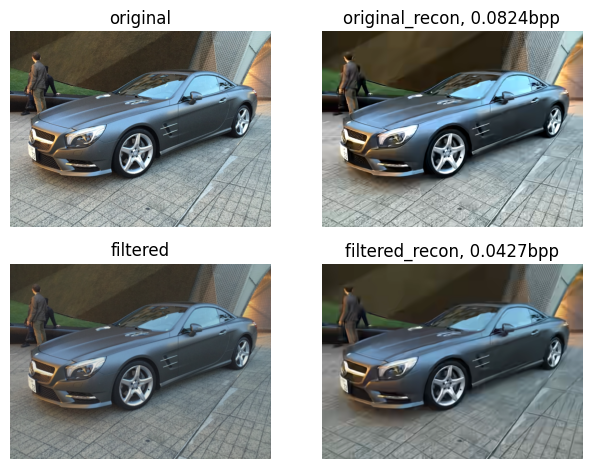

In [6]:
fig, axes = plt.subplots(2, 2)

for imgs, row_axes in zip(images, axes):
    for (name, data), ax in zip(imgs.items(), row_axes):
        if isinstance(data, Sequence):
            img, bpp = data
            title = name + f', {bpp:.4f}bpp'
        else:
            img = data
            title = name
        ax.axis(False)
        ax.set_title(title)
        ax.imshow(img)

plt.tight_layout()
plt.show()
fig.savefig('sample_output.png', dpi=500)

## Result Plotting

In [18]:
codec = 'vvenc'

base_result = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result.csv')
filter_result = pd.read_csv(saved_filter_model_path / 'result.csv')

base_result = base_result[base_result['codec'] == codec]
filter_result = filter_result[filter_result['codec'] == codec]

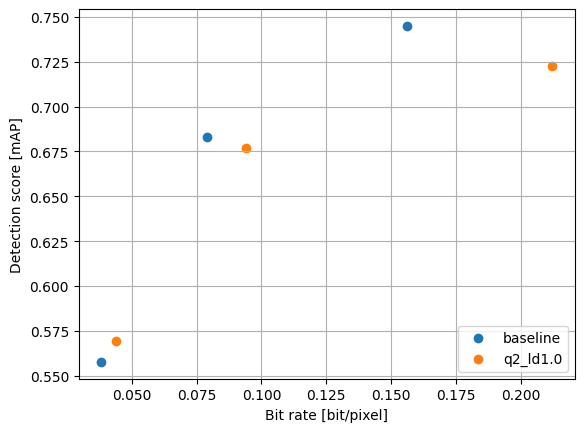

In [32]:
plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=filter_result['bpp'], y=filter_result['metric'], label=saved_filter_model_path.parent.name)
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.savefig('result.png', dpi=300)
plt.show()